In [15]:
from minisom import MiniSom

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
pd.options.display.float_format = '{:,.3f}'.format

In [17]:
# load numpy array from npy file
from numpy import load
# load array
X = load('X_G1iter.npy') #imputed with IterativeImputer
y = load('y_G1.npy')

In [18]:
data = pd.read_csv('data2_droplists.csv')
target = data['G1'].values

In [19]:
label_names = { 0 :'None', 1 :'Questionable', 2 :'Mild', 3 :'Moderate', 4 :'Severe'}

In [20]:
from sklearn import preprocessing
# data normalization
X = preprocessing.normalize(X)

In [21]:
target = [int(x) for x in target] #make floats to ints because the plot doesn't accept float

In [22]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### make functions of som

In [23]:
from hyperopt import fmin, tpe, hp
import time

In [24]:
from pylab import plot, axis, show, pcolor, colorbar, bone

In [25]:
def train_som(x, y, input_len, sigma, learning_rate):
    #initialize
    som = MiniSom(x=x,
                  y=y,
                  input_len=input_len,
                  sigma=sigma,
                  learning_rate=learning_rate,
                  neighborhood_function='bubble', random_seed=10
                  )
    som.random_weights_init(X)
    #train
    start_time = time.time()
    som.train_random(X, iterations, verbose=True)
    elapsed_time = time.time() - start_time
    print(elapsed_time, "seconds for training")
    return som

def plot_som(som):    
    plt.figure(figsize=(13, 9))
    pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
    colorbar()
    markers = ['o', '*', 'D', 's','^']
    colors = ['C1', 'C3', 'C0', 'C2', 'C4']
    for cnt, xx in enumerate(X):
        w = som.winner(xx) 
        plot(w[0]+.5, w[1]+.5, markers[target[cnt]], markerfacecolor='None',
                 markeredgecolor=colors[target[cnt]], markersize=12, markeredgewidth=2)
       
    show()

In [26]:
#set hyperparameters
rows_data =X.shape[0]
x = int(np.sqrt(5 * np.sqrt(rows_data)))
y = x
input_len = X.shape[1]
sigma = 5
learning_rate = 0.1
iterations = 450
print("number of dimensions x is {}".format(x))

number of dimensions x is 14


In [27]:
som = train_som(x, y, input_len, sigma, learning_rate)

 [ 450 / 450 ] 100% - 0:00:00 left 
 quantization error: 0.5164568637079671
2.5203092098236084 seconds for training


In [45]:
print("x: {}\ny: {}\ninput_len: {}\nsigma: {}\nlearning_rate: {}".format(x, 
                                                                         y, 
                                                                         input_len, 
                                                                         sigma, 
                                                                         learning_rate))

x: 14
y: 14
input_len: 667
sigma: 5
learning_rate: 0.1


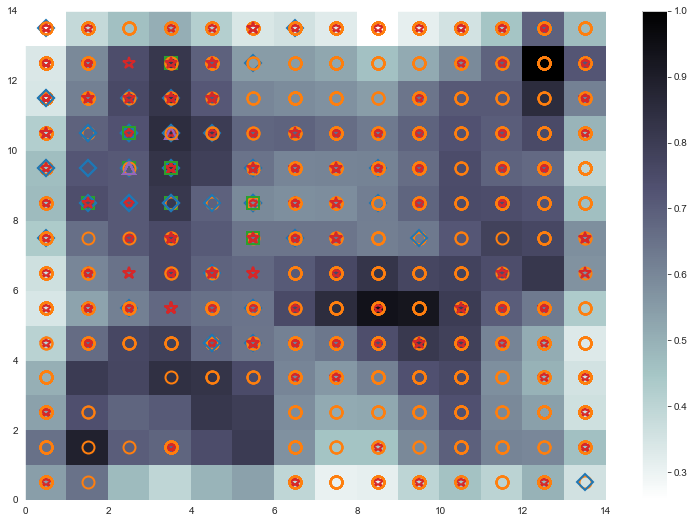

In [46]:
plot_som(som)

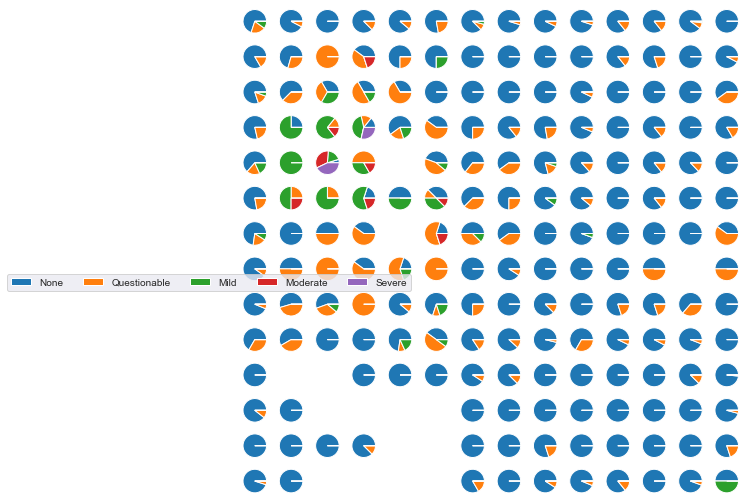

In [47]:
#visualize the proportion of samples per class falling in a specific neuron using a pie chart per neuron
import matplotlib.gridspec as gridspec

labels_map = som.labels_map(X, [label_names[t] for t in target])

fig = plt.figure(figsize=(9, 9))
the_grid = gridspec.GridSpec(x, y, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[x-1-position[1],
                         position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names.values(), bbox_to_anchor=(3.5, 6.5), ncol=5)
#plt.savefig('resulting_images/som_seed_pies.png')
plt.show()

#### tune sigma by reducing quantization error with hyperopt

In [48]:
start_time = time.time()
best = fmin(fn=lambda sig : MiniSom(x=x,
                                    y=y,
                                    input_len=input_len,
                                    sigma=sigma, 
                                    learning_rate=learning_rate, 
                                    ).quantization_error(X),
           space=hp.uniform("sig", 0.001, x/2.01),
           algo=tpe.suggest,
           max_evals=200)
elapsed_time = time.time() - start_time
print(elapsed_time, "seconds")
print(best)

100%|██████████| 200/200 [00:26<00:00,  7.65trial/s, best loss: 1.3188182450768553]
26.158584356307983 seconds
{'sig': 6.911939222808721}


In [13]:
sigma = int(best['sig'])

In [14]:
print("x: {}\ny: {}\ninput_len: {}\nsigma: {}\nlearning_rate: {}".format(x, 
                                                                         y, 
                                                                         input_len, 
                                                                         sigma, 
                                                                         learning_rate))

x: 14
y: 14
input_len: 667
sigma: 7
learning_rate: 0.1


In [15]:
som = train_som(x, y, input_len, sigma, learning_rate)

 [ 450 / 450 ] 100% - 0:00:00 left 
 quantization error: 0.5199720966388579
2.4289236068725586 seconds for training


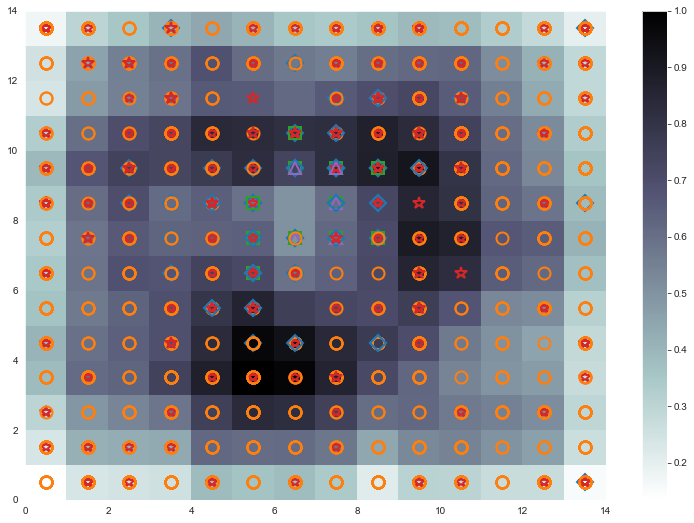

In [16]:
plot_som(som)

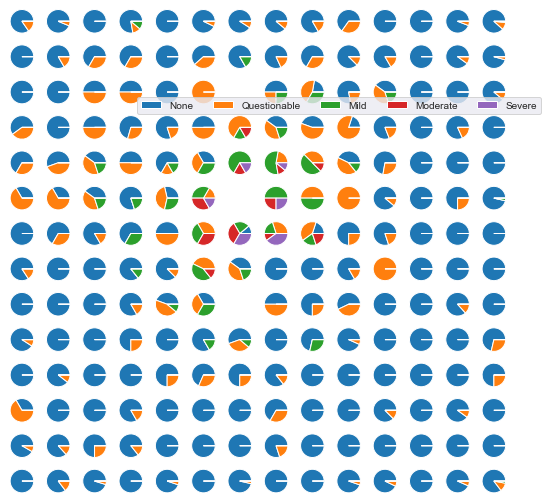

In [17]:
#visualize the proportion of samples per class falling in a specific neuron using a pie chart per neuron
import matplotlib.gridspec as gridspec

labels_map = som.labels_map(X, [label_names[t] for t in target])

fig = plt.figure(figsize=(9, 9))
the_grid = gridspec.GridSpec(x, y, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[x-1-position[1],
                         position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names.values(), bbox_to_anchor=(3.5, 6.5), ncol=5)
#plt.savefig('resulting_images/som_seed_pies.png')
plt.show()

In [18]:
#To visualize the quality of clustering of each neuron this map uses colors to show the mean difference of the values 
#corresponding to a neuron and the weights of the neuron. Neurons that aren't winning neuron for any sample are left blank.

import plotly.graph_objects as go

win_map = som.win_map(X)
size=som.distance_map().shape[0]
qualities=np.empty((size,size))
qualities[:]=np.NaN
for position, values in win_map.items():
    qualities[position[0], position[1]] = np.mean(abs(values-som.get_weights()[position[0], position[1]]))

layout = go.Layout(title='quality plot')
fig = go.Figure(layout=layout)
fig.add_trace(go.Heatmap(z=qualities, colorscale='Viridis'))
fig.show()

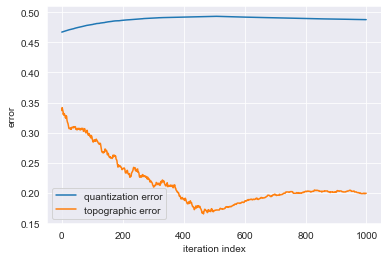

In [42]:
max_iter = 1000
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(X))
    som.update(X[rand_i], som.winner(X[rand_i]), i, max_iter)
    q_error.append(som.quantization_error(X))
    t_error.append(som.topographic_error(X))

plt.plot(np.arange(max_iter), q_error, label='quantization error')
plt.plot(np.arange(max_iter), t_error, label='topographic error')
plt.ylabel('error')
plt.xlabel('iteration index')
plt.legend()
plt.show()